In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

from sklearn.linear_model import Ridge, Lasso, RANSACRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import GridSearchCV
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

Сначала загружаем данные

In [2]:
categorial_features = ['month',
                       'year',
                       'waterfront',
                       'was_renovated',
                       'has_basement',
                       'floors',
                       'is_new_house',
                       'zipcode']

numeric_features = ['bedrooms',
                    'bathrooms',
                    'sqft_living',
                    #'sqft_living_log',
                    'sqft_lot',
                    #'sqft_lot_log',
                    'condition',
                    'grade',
                    'grade_condition',
                    'sqft_above',
                    'sqft_basement',
                    'yr_renovated',
                    'yr_built',
                    'lat',
                    'long',
                    'x','y','z'
                   ]


class data_transformer(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass
    
    def transform(self, x):
        res = x.copy()
        res['constant_feature'] = np.array([1 for _ in range(res.shape[0])])
        res['month'] = res['date'].dt.month
        res['year'] = res['date'].dt.year
        res['sqft_living'] = np.log(res['sqft_living'])
        res['sqft_lot'] = np.log(res['sqft_lot'])
        res['sqft_above'] = np.log(res['sqft_above'])
        res['has_basement'] = res['sqft_basement'] > 0
        res['was_renovated'] = res['yr_renovated'] > 0
        res['is_new_house'] = res['yr_built'] > 2005
        res['sqft_basement'] = np.sqrt(res['sqft_basement'])
        res['bedrooms'] = res['bedrooms']**2
        res['grade_condition'] = res['grade'] * res['condition']
        #res['floors'] = res['floors']**2
        res['x'] = np.cos(res['lat']) * np.cos(res['long'])
        res['y'] = np.cos(res['lat']) * np.sin(res['long'])
        res['z'] = np.sin(res['lat'])
        res = res.drop(columns=['date'])
        return res
    
    def fit(self, x, y=None, **fit_params):
        return self

def mape_score(y_true, y_pred, **kwarg):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.round(np.mean(np.absolute((y_true - y_pred) / y_true)) * 100, 4)

def load_data(path):
    data = pd.DataFrame(np.load(path))
    data['date'] = pd.to_datetime(data['date'])
    return data

def make_submit(model):
    x_valid = load_data('data/x_test.npy')
    y_pred = np.exp(model.predict(x_valid))
    target_pred = pd.DataFrame(y_pred)
    target_pred.columns = ['Price']
    target_pred.index.name = 'Id'
    target_pred.index += 1
    target_pred.to_csv('pred.csv')

def get_scores(scores, y_true, y_pred):
    for score in scores:
        print(score.__name__, score(y_true=y_true, y_pred=y_pred))


In [3]:
from sklearn.model_selection import train_test_split
x_data = load_data('data/x_train.npy')
y_data = pd.DataFrame(np.load('data/y_train.npy'))
print('Loaded data with %d samples' % len(x_data))
x_data.dtypes

Loaded data with 15000 samples


date             datetime64[ns]
bedrooms                float32
bathrooms               float32
sqft_living               int32
sqft_lot                  int32
floors                  float32
waterfront                 bool
condition                 int32
grade                     int32
sqft_above                int32
sqft_basement             int32
yr_built                  int32
yr_renovated              int32
zipcode                   int32
lat                     float32
long                    float32
dtype: object

/home/anna/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


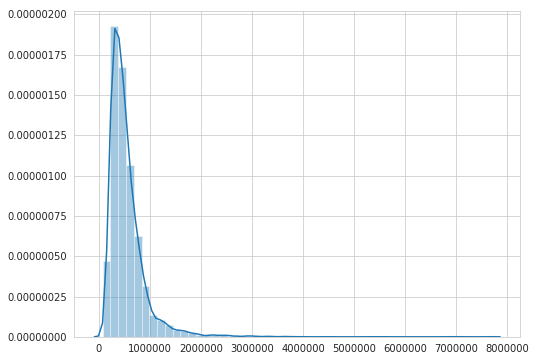

In [4]:
plt.figure(figsize=(8, 6))
y = y_data.values
sns.distplot(y)

Видим странное распределение, похожее на нормальное. Попробуем взять логарифм

/home/anna/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


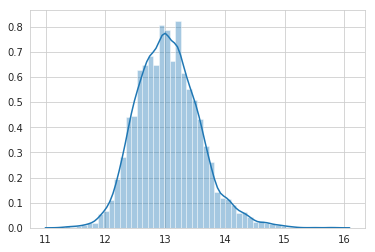

In [5]:
y_log = np.log(y_data)
sns.distplot(y_log)

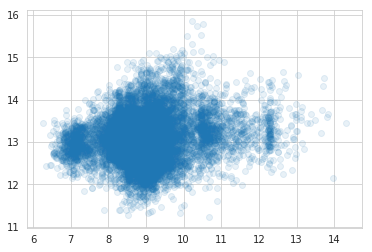

In [6]:
plt.scatter(np.log(x_data['sqft_lot']), y_log, alpha=.1)

In [7]:
def pairplot(df, target):
    ncol, nrow = 4, df.shape[1] // 4 + (df.shape[1] % 4 > 0)
    plt.figure(figsize=(ncol * 4, nrow * 4))

    for i, feature in enumerate(df.columns):
        plt.subplot(nrow, ncol, i + 1)
        plt.scatter(df[feature].values, target.values, s=10, marker='o', alpha=.6)
        plt.xlabel(feature)
        if i % ncol == 0:
            plt.ylabel('target')

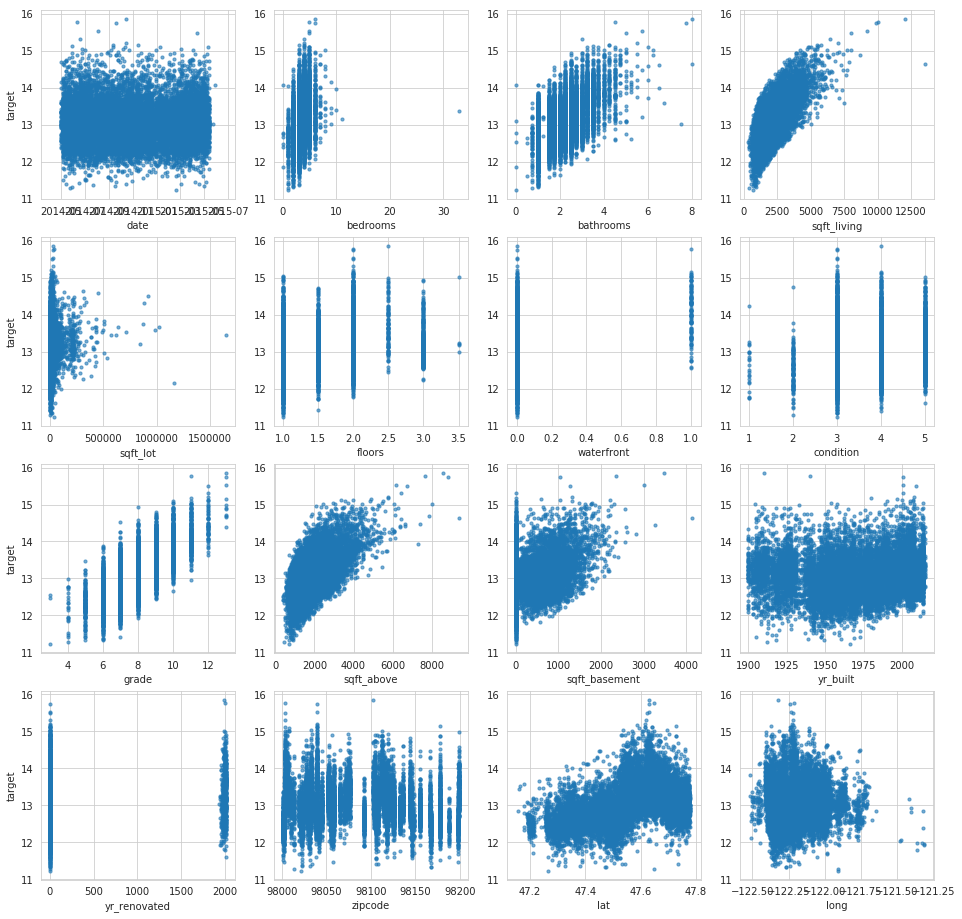

In [8]:
pairplot(x_data, y_log)

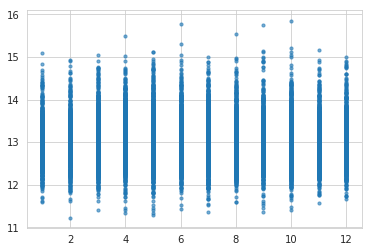

In [9]:
plt.scatter(x_data['date'].dt.month, y_log.values, s=10, marker='o', alpha=.6)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(x_data, y_log, test_size=0.3, random_state=42)

In [11]:
alphas = np.logspace(-4, -1, 3)
degrees = list(range(2, 3))

def get_best_models(x_train, y_train):
    pipe = Pipeline(
            [('transform and drop', data_transformer()),
             ('encoding', ColumnTransformer([('one_hot_encode',
                                              OneHotEncoder(sparse=False, handle_unknown='ignore', categories='auto'),
                                              categorial_features),
                                            ('scaler', StandardScaler(), numeric_features),
                                            ('polynom', PolynomialFeatures(degree=2), numeric_features)],
                                            sparse_threshold=0,
                                            remainder='passthrough')),
             ('regressor', Ridge())])
    search_params = [
        {
            'encoding__polynom': [PolynomialFeatures()],
            'encoding__polynom__degree' : degrees,
            'encoding__scaler': [MinMaxScaler(), StandardScaler()],
            'regressor':[Ridge(normalize=False)],
            'regressor__max_iter' : [2500],
            'regressor__alpha': alphas,
        }        
    ]
    gs_cv = GridSearchCV(pipe, param_grid=search_params, refit=True,
                         cv=5, return_train_score=True, verbose=1,
                         scoring=make_scorer(mape_score, greater_is_better=False))
    gs_cv.fit(x_train, y_train)
    return gs_cv

In [12]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.simplefilter(action='ignore', category=DataConversionWarning)

In [13]:
cv = get_best_models(x_train, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/home/anna/.local/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.909430e-21
  overwrite_a=True).T
/home/anna/.local/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.989898e-21
  overwrite_a=True).T
/home/anna/.local/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.881931e-21
  overwrite_a=True).T
/home/anna/.local/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:125: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guar

In [14]:
best_model = cv.best_estimator_
cv.best_params_

{'encoding__polynom': PolynomialFeatures(degree=2, include_bias=True, interaction_only=False),
 'encoding__polynom__degree': 2,
 'encoding__scaler': MinMaxScaler(copy=True, feature_range=(0, 1)),
 'regressor': Ridge(alpha=0.0031622776601683794, copy_X=True, fit_intercept=True,
    max_iter=2500, normalize=False, random_state=None, solver='auto',
    tol=0.001),
 'regressor__alpha': 0.0031622776601683794,
 'regressor__max_iter': 2500}

In [15]:
get_scores([mape_score, mean_absolute_error], y_pred=(np.exp(best_model.predict(x_test))), y_true=np.exp(y_test))

mape_score 12.715
mean_absolute_error 69787.35005706969


In [16]:
make_submit(model=best_model)